## Fast Benchmarking and Character Cycle Benchmarking for Non-Clifford Gate
#### Yihong Zhang

## Pre-setting
### 1) basic function definition

In [1]:
# -*- coding: utf-8 -*-
"""
author: YihongZhang
"""
%pylab inline
%matplotlib inline
import numpy as np
import qutip as qt
import qutip.qip.circuit as qtcir
from qutip.qip.operations.gates import qubit_clifford_group
import qiskit as qk
import scipy as sp
import random as Random
import heapq as hp
from functools import reduce
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm

#def func(x, p, A, B):
#    return A * (p ** x) + B

def func(x, p, A):
    return A * (p ** x)

def chop(expr, delta=10**-10):
    return np.ma.masked_inside(expr, -delta, delta).filled(0)

#np.set_printoptions(threshold=np.inf)  #Full display the matrix

Populating the interactive namespace from numpy and matplotlib


### 2) generation for $n$-qubit Pauli group

In [2]:
#1-qubit Pauli group
Pauli1Q = [qt.identity(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]

def number_convert(initial_num, notation_num, length):
    temp = []
    while True:
        quotient = initial_num // notation_num
        remainder = initial_num % notation_num
        temp = temp + [remainder]
        if quotient == 0:
            break
        initial_num = quotient
    result = np.zeros(max(length, len(temp)), int8)
    for i in range(len(temp)):
        result[- 1 - i] = temp[i]
    return result

def local_group(num_qubit, singleQubit_group):
    temp = []
    num_group = len(singleQubit_group)
    if num_qubit > 1:
        for i in range(num_group ** num_qubit):
            seq = number_convert(i, num_group, num_qubit)
            temp_gate = singleQubit_group[seq[0]]
            for j in range(num_qubit - 1):
                temp_gate = qt.tensor(temp_gate, singleQubit_group[seq[j + 1]])
            temp.append(temp_gate)
    else:
        temp = singleQubit_group
    return temp

### 3) transformation between computational basis and super-operator rep

In [3]:
def state_to_superrep(pure_state, rep_space):
    d = pure_state.shape[0]
    density_matrix = qt.ket2dm(pure_state)
    temp = np.zeros((len(rep_space), 1))
    for i in range(len(rep_space)):
        temp[i, 0] = (rep_space[i].dag() * density_matrix).tr() / np.sqrt(d)
    return temp

def measure_to_superrep(measure_basis, rep_space):
    d = measure_basis.shape[0]
    temp = np.zeros((1, len(rep_space)))
    for i in range(len(rep_space)):
        temp[0, i] = (measure_basis.dag() * rep_space[i]).tr() / np.sqrt(d)
    return temp

def channel_to_superrep(element, rep_space):
    temp = np.zeros((len(rep_space), len(rep_space)))
    for i in range(len(rep_space)):
        for j in range(len(rep_space)):
            temp[i, j] = (rep_space[i].dag() * element * rep_space[j] * element.dag()).tr()
    return temp

def superrep_to_choi(channel_superrep):
    num_qubit = int(math.log(len(channel_superrep), 4))
    temp = 0
    Pauli = local_group(num_qubit, Pauli1Q)
    for i in range(len(Pauli)):
        for j in range(len(Pauli)):
            temp = temp + channel_superrep[i, j] * qt.tensor(Pauli[i].trans(), Pauli[j])
    return temp / (4**num_qubit)

def dep_superrep(t, p, num_qubit):
    temp = np.zeros((4**num_qubit, 4**num_qubit))
    temp[0, 0] = t
    for i in range(4**num_qubit - 1):
        temp[i + 1, i + 1] = p
    return temp

def PauliChan_surerrep(pauli_eigvals):
    if(len(pauli_eigvals) != 4**num_qubit - 1):
        print('The number of input Pauli eigenvalues are wrong.')
        return
    temp = np.zeros((4**num_qubit, 4**num_qubit))
    temp[0, 0] = 1
    for i in range(4**num_qubit - 1):
        temp[i + 1, i + 1] = pauli_eigvals[i]
    return temp

def local_group_superrep(num_qubit, singleQubit_group):
    temp = []
    group_superrep = []
    num_group = len(singleQubit_group)
    for i in range(num_group):
        group_superrep.append(unitary_superrep(singleQubit_group[i], Pauli1Q))
    for i in range(num_group ** num_qubit):
        seq = number_convert(i, num_group, num_qubit)
        temp_gate = 1
        for j in range(num_qubit):
            temp_gate = np.kron(temp_gate, group_superrep[seq[j]])
        temp.append(temp_gate)
    return temp

def unitary_superrep(unitary, rep_space):
    d = unitary.shape[0]
    temp = np.zeros((len(rep_space), len(rep_space)))
    #temp = np.zeros((len(rep_space), len(rep_space)), dtype=complex)
    for i in range(len(rep_space)):
        for j in range(len(rep_space)):
            temp[i, j] = chop(((rep_space[i].dag() / np.sqrt(d)) * unitary * (rep_space[j] / np.sqrt(d)) * unitary.dag()).tr().real)
            #temp[i, j] = chop(((rep_space[i].dag() / np.sqrt(d)) * unitary * (rep_space[j] / np.sqrt(d)) * unitary.dag()).tr())
    return temp

def twirling(channel_superrep, group_superrep):
    num_qubit = int(math.log(len(group_superrep[0]), 4))
    temp = 0
    for i in range(len(group_superrep)):
        temp += np.dot(np.dot(group_superrep[i].conj().T, channel_superrep), group_superrep[i])
    temp /= len(group_superrep)
    return temp

def process_fidelity(channel_superrep):
    return np.trace(channel_superrep) / len(channel_superrep)

def sqrt_fidelity(channel_superrep):
    val, vec = np.linalg.eig(channel_superrep)
    init_channel = np.diag(val)
    return np.trace(np.sqrt(init_channel)) / len(val)

## Error model definition and some basic process function definition
### 1) error channel for local Pauli group

A noisy 1-qubit gate can be described by
\begin{equation}
\tilde{\mathcal{G}} = \mathcal{G} \circ \Lambda_{Rz} \circ \Lambda_{1dep},
\end{equation}
where
\begin{equation}
\begin{split}
&\Lambda_{Rz} = Rz(\theta), \\
&\Lambda_{1dep}(\rho) = p_1\rho + (t_1-p_1)\frac{I}{d_1}, d_1 = 2.
\end{split}
\end{equation}

In [4]:
num_qubit = 2
Pauli_group = local_group(num_qubit, Pauli1Q)

theta_list = np.arange(0.001, 0.001 + num_qubit * 0.001, 0.001)
t_list = np.zeros(num_qubit) + 1
p_list = np.arange(0.999, 0.999 - num_qubit * 0.0012, - 0.0012)
#p_list = [0.998, 0.5]
phase_chan = []
dep_chan = []
chan_list = []
Pauli_channel = 1
for i in range(num_qubit):
    temp_phase = unitary_superrep(qtcir.rz(theta_list[i]), Pauli1Q)
    temp_dep = dep_superrep(t_list[i], p_list[i], 1)
    phase_chan.append(temp_phase)
    dep_chan.append(temp_dep)
    chan_list.append(np.dot(temp_phase, temp_dep))
    Pauli_channel = np.kron(chan_list[i], Pauli_channel)

print('The theoretic process fidelity for the gate of local Pauli group is', process_fidelity(Pauli_channel))

The theoretic process fidelity for the gate of local Pauli group is 0.9975999911110396


### 2) SPAM error channel

SPAM error channel is similar to the Pauli channel, here we treat them as the same.

In [5]:
theta_SPAM_list = np.arange(0.01, 0.01 + num_qubit * 0.01, 0.01)
t_SPAM_list = np.zeros(num_qubit) + 1
p_SPAM_list = np.arange(0.999, 0.999 - num_qubit * 0.0015, - 0.0015)
phase_SPAM_chan = []
dep_SPAM_chan = []
chan_SPAM_list = []
SPAM_channel = 1
for i in range(num_qubit):
    temp_phase = unitary_superrep(qtcir.rz(theta_SPAM_list[i]), Pauli1Q)
    temp_dep = dep_superrep(t_SPAM_list[i], p_SPAM_list[i], 1)
    phase_SPAM_chan.append(temp_phase)
    dep_SPAM_chan.append(temp_dep)
    chan_SPAM_list.append(np.dot(temp_phase, temp_dep))
    SPAM_channel = np.kron(chan_SPAM_list[i], SPAM_channel)

print('The theoretic process fidelity for the gate of SPAM group is', process_fidelity(SPAM_channel))

The theoretic process fidelity for the gate of SPAM group is 0.9972518089119731


### 3) 2-qubit non-Clifford gate and its error channel

In [6]:
cnot = qtcir.cnot()
sqrtT1 = qt.tensor(qtcir.identity(2), qtcir.rz(pi/16))
sqrtT2 = qt.tensor(qtcir.identity(2), qtcir.rz(-pi/16))
X12 = qt.tensor(qt.sigmax(), qt.sigmax())
target_gate = sqrtT1 * cnot * sqrtT2

Tgate = qtcir.rz(pi/8)
target_gate == qtcir.controlled_gate(Tgate, N=2, control=0, target=1) * cnot

True

A noisy 2-qubit non-Clifford gate can by decribed by
\begin{equation}
\tilde{C} = C \circ \Lambda_{U},
\end{equation}
where
\begin{equation}
\Lambda_U = \Lambda_{co} \circ \Lambda_{dep},
\end{equation}
here $\Lambda_{co}$ is the coherent error, $\Lambda_{dep}$ is the depolarizing channel. We have
\begin{equation}
\begin{split}
& \Lambda_{co} = \mathrm{expm}(ic \mathrm{SWAP}_{12}), \\
& \Lambda_{dep}(\rho) = p\rho + (t-p)\frac{I}{d}, d = 2^2.
\end{split}
\end{equation}

In [416]:
#parameters setting
[set_fidelity, set_var] = [0.97, 0.001]
def Pauli_eig(set_fidelity, set_var, num_qubit):
    temp_eig = np.random.normal(loc = set_fidelity, scale = set_var, size = 4**num_qubit - 1)
    for i in range(4**num_qubit - 1):
        if(temp_eig[i] > 1):
            temp_eig[i] = 0.9999
    return temp_eig
#Pauli_chan = PauliChan_surerrep(Pauli_eig(set_fidelity, set_var, num_qubit))

p_target_list = np.arange(0.999, 0.999 - (4**num_qubit - 1) * 0.004 + 0.0001, - 0.004)
Pauli_chan = PauliChan_surerrep(p_target_list)

c = 0.01
channel_co = (1j * c * qtcir.swap()).expm()
channel_co_superrep = unitary_superrep(channel_co, Pauli_group)

#TargetGate_channel = np.dot(channel_co_superrep, Pauli_chan)
#print('The theoretic process fidelity for the target clifford gate is', process_fidelity(TargetGate_channel))

#### fidelity information

In [16]:
channel = np.dot(Pauli_channel, TargetGate_channel)
ini_fidelity = process_fidelity(channel)
print('The fidelity of the error channel is', ini_fidelity)

channel_Pauli_twirling = twirling(channel, twirling_group)
inter_channel = sqrtm(chop(np.dot(channel_Pauli_twirling, np.dot(np.dot(int_gate, channel_Pauli_twirling), int_gate.T.conjugate()))))
inter_fidelity = np.trace(inter_channel) / 4**num_qubit
print('The fidelity of the interleaved error channel is', inter_fidelity)

The fidelity of the error channel is 0.9704191806551774
The fidelity of the interleaved error channel is 0.9703288769037108


### 3) SPAM settings

In [7]:
[X_state0, X_state1] = [(qt.ket("0") + qt.ket("1")).unit(), (qt.ket("0") - qt.ket("1")).unit()]
[Y_state0, Y_state1] = [(qt.ket("0") + 1j * qt.ket("1")).unit(), (qt.ket("0") - 1j * qt.ket("1")).unit()]
[Z_state0, Z_state1] = [qt.ket("0"), qt.ket("1")]

class SPAM_setting:
    
    def __init__(self, basis_setting):
        self.setting = basis_setting
        self.num = len(basis_setting)
        self.initial_state = np.zeros(4**self.num)
        self.measure_observable = np.zeros(4**self.num)
        self.measure_basis = []
        self.Allmeasure_basis_result = []
    
    def add_initial_state(self):
        temp = 1
        for i in range(self.num):
            if self.setting[i] == 'I':
                temp = np.kron(temp, state_to_superrep(Z_state0, Pauli1Q))
            elif self.setting[i] == 'X':
                temp = np.kron(temp, state_to_superrep(X_state0, Pauli1Q))
            elif self.setting[i] == 'Y':
                temp = np.kron(temp, state_to_superrep(Y_state0, Pauli1Q))
            elif self.setting[i] == 'Z':
                temp = np.kron(temp, state_to_superrep(Z_state0, Pauli1Q))
            else:
                print('The input format is wrong.')
        self.initial_state = temp
    
    def add_measure_observable(self):
        temp = 1
        for i in range(self.num):
            if self.setting[i] == 'I':
                temp = np.kron(temp, measure_to_superrep(qt.identity(2), Pauli1Q))
            elif self.setting[i] == 'X':
                temp = np.kron(temp, measure_to_superrep(qt.sigmax(), Pauli1Q))
            elif self.setting[i] == 'Y':
                temp = np.kron(temp, measure_to_superrep(qt.sigmay(), Pauli1Q))
            elif self.setting[i] == 'Z':
                temp = np.kron(temp, measure_to_superrep(qt.sigmaz(), Pauli1Q))
            else:
                print('The input format is wrong.')
        self.measure_observable = temp
    
    def add_measure_basis(self):
        temp_setting = []
        order = np.zeros(self.num)
        for i in range(self.num):
            if self.setting[i] == 'X':
                order[i] = 1
                temp_setting.append([[measure_to_superrep(qt.ket2dm(X_state0), Pauli1Q), 1], [measure_to_superrep(qt.ket2dm(X_state1), Pauli1Q), -1]])
            elif self.setting[i] == 'Y':
                order[i] = 1
                temp_setting.append([[measure_to_superrep(qt.ket2dm(Y_state0), Pauli1Q), 1], [measure_to_superrep(qt.ket2dm(Y_state1), Pauli1Q), -1]])
            elif self.setting[i] == 'Z':
                order[i] = 1
                temp_setting.append([[measure_to_superrep(qt.ket2dm(Z_state0), Pauli1Q), 1], [measure_to_superrep(qt.ket2dm(Z_state1), Pauli1Q), -1]])
        for j in range(2**int(sum(order))):
            temp_state = 1
            temp_measure_result = 1
            temp_order = 0
            seq = number_convert(j, 2, int(sum(order)))
            for k in range(self.num):
                if order[k] == 1:
                    temp_state = np.kron(temp_state, temp_setting[temp_order][seq[temp_order]][0])
                    temp_measure_result *= temp_setting[temp_order][seq[temp_order]][1]
                    temp_order += 1
                else:
                    temp_state = np.kron(temp_state, measure_to_superrep(qt.identity(2), Pauli1Q))
            self.measure_basis.append([temp_state, temp_measure_result])
            
    def measure_basis_result(self):
        temp_setting = []
        for i in range(self.num):
            if self.setting[i] == 'X':
                temp_setting.append([[measure_to_superrep(qt.ket2dm(X_state0), Pauli1Q), 1], [measure_to_superrep(qt.ket2dm(X_state1), Pauli1Q), -1]])
            elif self.setting[i] == 'Y':
                temp_setting.append([[measure_to_superrep(qt.ket2dm(Y_state0), Pauli1Q), 1], [measure_to_superrep(qt.ket2dm(Y_state1), Pauli1Q), -1]])
            elif self.setting[i] == 'Z':
                temp_setting.append([[measure_to_superrep(qt.ket2dm(Z_state0), Pauli1Q), 1], [measure_to_superrep(qt.ket2dm(Z_state1), Pauli1Q), -1]])
            else:
                print('The measurement basis is not complete.')
        for j in range(2**self.num):
            temp_state = 1
            temp_measure_result = []
            seq = number_convert(j, 2, self.num)
            for k in range(self.num):
                temp_state = np.kron(temp_state, temp_setting[k][seq[k]][0])
                temp_measure_result.append(temp_setting[k][seq[k]][1])
            self.Allmeasure_basis_result.append([temp_state, temp_measure_result])

### 4) Quantum process function

In [13]:
sqrtT1_superrep = unitary_superrep(sqrtT1, Pauli_group)
sqrtT2_superrep = unitary_superrep(sqrtT2, Pauli_group)

# generation of local clifford group
cliff1Q_generator = qubit_clifford_group(1,0)
Clifford1Q = []
for i in range(24):
    Clifford1Q.append(cliff1Q_generator.__next__())
Clifford_superrep = local_group_superrep(num_qubit, Clifford1Q)
num_Clifford = len(Clifford_superrep)
Clifford_twirling = []
for i in range(num_Clifford):
    Clifford_twirling.append(chop(np.dot(np.dot(sqrtT1_superrep, Clifford_superrep[i]), sqrtT2_superrep)))

Pauli_superrep = local_group_superrep(num_qubit, Pauli1Q)
num_twirling = len(Pauli_superrep)
twirling_group = []
for i in range(num_twirling):
    twirling_group.append(chop(np.dot(np.dot(sqrtT1_superrep, Pauli_superrep[i]), sqrtT2_superrep)))

int_gate = unitary_superrep(target_gate, Pauli_group)
#int_gate_channel = TargetGate_channel
ref_gate_channel = Pauli_channel

#### RB process

In [9]:
class RB_process:
    
    def __init__(self, seq_length, int_gate, SPAM_channel, ref_gate_channel, int_gate_channel):
        self.seq_length = seq_length
        self.int_gate = int_gate
        self.SPAM_channel = SPAM_channel
        self.ref_gate_channel = ref_gate_channel
        self.int_gate_channel = int_gate_channel
        
        self.full_process = []
        self.full_character = []
        self.fast_process = []
        self.XEB_process = []
        self.XEB_gate = []
        
    def compute_full_process(self):
        sample_num0 = Random.randrange(0, num_twirling)
        sample_ideal_process0 = twirling_group[sample_num0]
        sample_ideal_process = 1
        sample_noisy_process = np.dot(self.SPAM_channel, sample_ideal_process0)
        for i in range(self.seq_length):
            sample_num = Random.randrange(0, num_twirling)
            sample_noisy_process = np.dot(np.dot(self.ref_gate_channel, twirling_group[sample_num]), sample_noisy_process)
            sample_noisy_process = np.dot(np.dot(self.int_gate, self.int_gate_channel), sample_noisy_process)
            sample_ideal_process = np.dot(self.int_gate, np.dot(twirling_group[sample_num], sample_ideal_process))
        sample_noisy_process = np.dot(self.SPAM_channel, np.dot(sample_ideal_process.T.conj(), sample_noisy_process))
        self.full_process = sample_noisy_process
        self.full_character = sample_ideal_process0
    
    def compute_fast_process(self):
        clifford_num = Random.randrange(0, num_Clifford)
        dressed_clifford = Clifford_twirling[clifford_num]
        sample_ideal_process = dressed_clifford
        sample_noisy_process = dressed_clifford
        for i in range(self.seq_length):
            sample_num = Random.randrange(0, num_twirling)
            sample_noisy_process = np.dot(np.dot(self.ref_gate_channel, twirling_group[sample_num]), sample_noisy_process)
            sample_noisy_process = np.dot(np.dot(self.int_gate, self.int_gate_channel), sample_noisy_process)
            sample_ideal_process = np.dot(self.int_gate, np.dot(twirling_group[sample_num], sample_ideal_process))
        sample_noisy_process = np.dot(sample_ideal_process.T.conj(), sample_noisy_process)
        self.fast_process = sample_noisy_process
        
    def compute_XEB_process(self):
        sample_ideal_process = 1
        sample_noisy_process = 1
        for i in range(self.seq_length):
            sample_num = Random.randrange(0, num_Clifford)
            sample_noisy_process = np.dot(np.dot(self.ref_gate_channel, Clifford_twirling[sample_num]), sample_noisy_process)
            sample_noisy_process = np.dot(np.dot(self.int_gate, self.int_gate_channel), sample_noisy_process)
            sample_ideal_process = np.dot(self.int_gate, np.dot(Clifford_twirling[sample_num], sample_ideal_process))
        self.XEB_process = sample_noisy_process
        self.XEB_gate = sample_ideal_process

### 5) Measurement function

In [10]:
def basis_order_to_setting(order, num_qubit):
    order_array = number_convert(order, 4, num_qubit)
    basis_setting = ''
    for i in range(num_qubit):
        if order_array[i] == 0:
            basis_setting += 'I'
        elif order_array[i] == 1:
            basis_setting += 'X'
        elif order_array[i] == 2:
            basis_setting += 'Y'
        elif order_array[i] == 3:
            basis_setting += 'Z'
        else:
            print('The basis converted number is wrong.')
    return basis_setting

class RB_measure:
    
    def __init__(self, quantum_process):
        self.process = quantum_process
        self.full_prob = -1
        self.fast_prob = []
        self.XEB_prob = -1
        
    def compute_full_prob(self, character_gate, character_order):
        basis = SPAM_setting(basis_order_to_setting(character_order, num_qubit))
        basis.add_initial_state()
        basis.add_measure_observable()
        state = np.dot(sqrtT1_superrep, basis.initial_state)
        observable = np.dot(basis.measure_observable, sqrtT2_superrep)
        prob = character_gate[character_order, character_order] * np.dot(observable, np.dot(self.process, state))
        self.full_prob = prob[0][0]
    
    def compute_fast_prob(self):
        for i in range(2**num_qubit - 1):
            temp_basis = number_convert(i + 1, 2, num_qubit)
            temp_order = 0
            for j in range(num_qubit):
                temp_order += 3 * temp_basis[-j-1] * (4**j)
            basis = SPAM_setting(basis_order_to_setting(temp_order, num_qubit))
            basis.add_initial_state()
            basis.add_measure_observable()
            state = np.dot(sqrtT1_superrep, basis.initial_state)
            observable = np.dot(basis.measure_observable, sqrtT2_superrep)
            prob = np.dot(observable, np.dot(self.process, state))
            self.fast_prob.append(prob[0][0])
            
    def compute_XEB_prob(self):
        temp_order = 0
        for j in range(num_qubit):
            temp_order += 3 * (4**j)
        basis = SPAM_setting(basis_order_to_setting(temp_order, num_qubit))
        basis.add_initial_state()
        basis.add_measure_observable()
        prob = np.dot(basis.measure_observable, np.dot(self.process, basis.initial_state))
        self.XEB_prob = prob[0][0]

### 6) Experiment simulation

In [11]:
class RB_experiment:
    
    def __init__(self, num_seq, seq_length, int_gate, SPAM_channel, ref_gate_channel, int_gate_channel):
        self.num_seq = num_seq
        self.seq_length = seq_length
        self.int_gate = int_gate
        self.SPAM_channel = SPAM_channel
        self.ref_gate_channel = ref_gate_channel
        self.int_gate_channel = int_gate_channel
        
        self.full_ave_prob_order = -1
        self.fast_ave_prob = -1
        self.XEB_ave_prob = -1
    
    def full_simulation(self, character_order):
        temp = []
        for i in range(self.num_seq):
            process = RB_process(self.seq_length, self.int_gate, self.SPAM_channel, self.ref_gate_channel, self.int_gate_channel)
            process.compute_full_process()
            measure = RB_measure(process.full_process)
            measure.compute_full_prob(process.full_character, character_order)
            temp.append(measure.full_prob)
        self.full_ave_prob_order = np.mean(temp)
    
    def fast_simulation(self):
        temp = []
        for i in range(self.num_seq):
            process = RB_process(self.seq_length, self.int_gate, self.SPAM_channel, self.ref_gate_channel, self.int_gate_channel)
            process.compute_fast_process()
            measure = RB_measure(process.fast_process)
            measure.compute_fast_prob()
            temp.append(measure.fast_prob)
        self.fast_ave_prob = np.array(temp).mean(axis = 0)
    
    def XEB_simulation(self):
        temp = []
        for i in range(self.num_seq):
            process = RB_process(self.seq_length, self.int_gate, self.SPAM_channel, self.ref_gate_channel, self.int_gate_channel)
            process.compute_XEB_process()
            measure = RB_measure(process.XEB_process)
            measure.compute_XEB_prob()
            temp.append(measure.XEB_prob)
        self.XEB_ave_prob = np.mean(temp)
        

def twirling_ideal(channel, seq_length_total, character_order):
    twirling_p = twirling(channel, twirling_group)[character_order, character_order]
    twirling_temp = []
    for l in range(seq_length_total):
        twirling_temp.append(twirling_p ** (l + 1))
    return twirling_temp

### 7) Simulation
#### (i) fitting method

In [412]:
# calculate the survival probability for the CCB, FB fitting protocols
# the calculations are determined by the Pauli irrep order
def full_prob_order(num_seq, seq_length_total, seq_length_step, basis_order, int_gate, SPAM_channel, ref_gate_channel, int_gate_channel):
    ave_prob = []
    for l in range(2, seq_length_total + 2, seq_length_step):
        experiment = RB_experiment(num_seq, l, int_gate, SPAM_channel, ref_gate_channel, int_gate_channel)
        experiment.full_simulation(basis_order)
        ave_prob.append(experiment.full_ave_prob_order)
    return ave_prob

def fullRB(num_irrep, num_seq, seq_length_total, seq_length_step, int_gate, SPAM_channel, ref_gate_channel, int_gate_channel):
    result = []
    for i in range(num_irrep):
        temp_order = Random.randrange(1, 4 ** num_qubit - 1)
        result.append(full_prob_order(num_seq, seq_length_total, seq_length_step, temp_order, int_gate, SPAM_channel, ref_gate_channel, int_gate_channel))
    return np.array(result)

def fastRB(num_seq, seq_length_total, seq_length_step, int_gate, SPAM_channel, ref_gate_channel, int_gate_channel):
    ave_prob = []
    for l in range(2, seq_length_total + 2, seq_length_step):
        experiment = RB_experiment(num_seq, l, int_gate, SPAM_channel, ref_gate_channel, int_gate_channel)
        experiment.fast_simulation()
        ave_prob.append(experiment.fast_ave_prob)
    return np.array(ave_prob).T

def XEB(num_seq, seq_length_total, seq_length_step, int_gate, SPAM_channel, ref_gate_channel, int_gate_channel):
    ave_prob = []
    for l in range(2, seq_length_total + 2, seq_length_step):
        experiment = RB_experiment(num_seq, l, int_gate, SPAM_channel, ref_gate_channel, int_gate_channel)
        experiment.XEB_simulation()
        ave_prob.append(experiment.XEB_ave_prob)
    return ave_prob

def RB_fitting(result, seq_length_step):
    irrep_fidelity = []
    num_irrep = len(result)
    xdata = range(1, len(result[0]) * int(seq_length_step / 2) + 1, int(seq_length_step / 2))
    for i in range(num_irrep):
        popt_original, pcov_original = curve_fit(func, xdata, result[i], p0 = [1, 1])
        irrep_fidelity.append(np.sqrt(popt_original[0]))
    return irrep_fidelity

def fullRB_fitting_analysis(num_exper, num_irrep, num_seq, seq_length_total, seq_length_step, int_gate, SPAM_channel, ref_gate_channel, int_gate_channel):
    fitting_result = []
    for i in range(num_exper):
        temp_RB = fullRB(num_irrep, num_seq, seq_length_total, seq_length_step, int_gate, SPAM_channel, ref_gate_channel, int_gate_channel)
        temp_fitting = RB_fitting(temp_RB, seq_length_step)
        fitting_result.append((np.mean(temp_fitting) * (4 ** num_qubit - 1) + 1) / (4 ** num_qubit))
        #print(i)
    return fitting_result

def fastRB_fitting_analysis(num_exper, num_seq, seq_length_total, seq_length_step, int_gate, SPAM_channel, ref_gate_channel, int_gate_channel):
    FB_weight = []
    for i in range(2**num_qubit - 1):
        temp_basis = number_convert(i + 1, 2, num_qubit)
        FB_weight.append(3 ** sum(temp_basis))
    fitting_result = []
    for i in range(num_exper):
        temp_RB = fastRB(num_seq, seq_length_total, seq_length_step, int_gate, SPAM_channel, ref_gate_channel, int_gate_channel)
        temp_fitting = RB_fitting(temp_RB, seq_length_step)
        fitting_result.append((np.dot(FB_weight, temp_fitting) + 1) / (4 ** num_qubit))
        #print(i)
    return fitting_result

def XEB_fitting_analysis(num_exper, num_seq, seq_length_total, seq_length_step, int_gate, SPAM_channel, ref_gate_channel, int_gate_channel):
    fitting_result = []
    for i in range(num_exper):
        temp_RB = XEB(num_seq, seq_length_total, seq_length_step, int_gate, SPAM_channel, ref_gate_channel, int_gate_channel)
    return 0


def fast_fitting_pre(num_exper, num_seq, seq_length_total, seq_length_step, int_gate, SPAM_channel, ref_gate_channel, int_gate_channel):
    plt.figure(figsize = (8, 6))
    exp_res = []
    for i in range(num_exper):
        exp_res.append(fastRB(num_seq, seq_length_total, seq_length_step, int_gate, SPAM_channel, ref_gate_channel, int_gate_channel))
        
    temp_prob_ave = []
    temp_prob_std = []
    for i in range(2**num_qubit - 1):
        temp_res = []
        for j in range(num_exper):
            temp_res.append(exp_res[j][i])
        temp_prob_ave.append(np.array(temp_res).mean(axis = 0))
        temp_prob_std.append(np.array(temp_res).std(axis = 0))
    return [temp_prob_ave, temp_prob_std]

def fast_fitting_figure(result, seq_length_step):
    plt.figure(figsize = (8, 6))
    xdata = range(2, len(result[0][0]) * seq_length_step + 2, seq_length_step)
    
    #IZ
    popt_original_IZ, pcov_original_IZ = curve_fit(func, xdata, result[0][0], p0 = [1, 1])
    y_IZ = [func(i, popt_original_IZ[0], popt_original_IZ[1]) for i in xdata]
    plt.plot(xdata, y_IZ, color="b", linewidth=2.0)  
    plt.errorbar(xdata, result[0][0], yerr = result[1][0], fmt='o',ecolor='r',color='b',elinewidth=2,capsize=4)
    
    #ZI
    popt_original_ZI, pcov_original_ZI = curve_fit(func, xdata, result[0][1], p0 = [1, 1])
    y_ZI = [func(i, popt_original_ZI[0], popt_original_ZI[1]) for i in xdata]
    plt.plot(xdata, y_ZI, color="green", linewidth=2.0)
    plt.errorbar(xdata, result[0][1], yerr = result[1][1], fmt='o',ecolor='r',color='green',elinewidth=4,capsize=4)
    
    
    #ZZ
    popt_original_ZZ, pcov_original_ZZ = curve_fit(func, xdata, result[0][2], p0 = [1, 1])
    y_ZZ = [func(i, popt_original_ZZ[0], popt_original_ZZ[1]) for i in xdata]
    plt.plot(xdata, y_ZZ, color="orange", linewidth=2.0)
    plt.errorbar(xdata, result[0][2], yerr = result[1][2], fmt='o',ecolor='r',color='orange',elinewidth=2,capsize=4)
    
    plt.xlabel("Sequence Length", fontsize = 16)
    plt.ylabel("Survival Probability", fontsize = 16)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    #plt.xlim((5.9, 6.1))
    #plt.ylim((0.7, 0.73))
    plt.legend(["$\lambda_{IZ}$", "$\lambda_{ZI}$", "$\lambda_{ZZ}$"], loc = 'upper right') 
    plt.savefig('fast_fitting.pdf')

### Fitting simulation
#### (1) [set_fidelity, set_var] = [0.98, 0.001]

In [385]:
seq_length_total = 51
seq_length_step = 6

In [386]:
full_fitting1 = fullRB_fitting_analysis(40, 10, 100, seq_length_total, seq_length_step)

In [387]:
fast_fitting1 = fastRB_fitting_analysis(40, 100, seq_length_total, seq_length_step)

In [389]:
channel1 = np.dot(Pauli_channel, TargetGate_channel)
ini_fidelity1 = process_fidelity(channel1)

channel_Pauli_twirling1 = twirling(channel1, twirling_group)
inter_channel1 = sqrtm(chop(np.dot(channel_Pauli_twirling1, np.dot(np.dot(int_gate, channel_Pauli_twirling1), int_gate.T.conjugate()))))
inter_fidelity1 = np.trace(inter_channel1) / 4**num_qubit


print('The fidelity of the error channel is', ini_fidelity1)
print('The fidelity of the interleaved error channel is', inter_fidelity1)
#print('The variance of the Pauli eigenvalues is', diag_var1)

The fidelity of the error channel is 0.9781365974222167
The fidelity of the interleaved error channel is 0.9781264414349802


#### (2) [set_fidelity, set_var] = [0.95, 0.001]

In [438]:
seq_length_total = 20
seq_length_step = 2

In [439]:
full_fitting2 = fullRB_fitting_analysis(40, 10, 100, seq_length_total, seq_length_step)

In [440]:
fast_fitting2 = fastRB_fitting_analysis(40, 100, seq_length_total, seq_length_step)

In [441]:
channel2 = np.dot(Pauli_channel, TargetGate_channel)
ini_fidelity2 = process_fidelity(channel2)

channel_Pauli_twirling2 = twirling(channel2, twirling_group)
inter_channel2 = sqrtm(chop(np.dot(channel_Pauli_twirling2, np.dot(np.dot(int_gate, channel_Pauli_twirling2), int_gate.T.conjugate()))))
inter_fidelity2 = np.trace(inter_channel2) / 4**num_qubit


print('The fidelity of the error channel is', ini_fidelity2)
print('The fidelity of the interleaved error channel is', inter_fidelity2)
#print('The variance of the Pauli eigenvalues is', diag_var1)

The fidelity of the error channel is 0.950566116843589
The fidelity of the interleaved error channel is 0.9505658282370548


#### (3) [set_fidelity, set_var] = [0.90, 0.001]

In [463]:
seq_length_total = 16
seq_length_step = 2

In [464]:
full_fitting3 = fullRB_fitting_analysis(40, 10, 100, seq_length_total, seq_length_step)

In [465]:
fast_fitting3 = fastRB_fitting_analysis(40, 100, seq_length_total, seq_length_step)

In [466]:
channel3 = np.dot(Pauli_channel, TargetGate_channel)
ini_fidelity3 = process_fidelity(channel3)

channel_Pauli_twirling3 = twirling(channel3, twirling_group)
inter_channel3 = sqrtm(chop(np.dot(channel_Pauli_twirling3, np.dot(np.dot(int_gate, channel_Pauli_twirling3), int_gate.T.conjugate()))))
inter_fidelity3 = np.trace(inter_channel3) / 4**num_qubit


print('The fidelity of the error channel is', ini_fidelity3)
print('The fidelity of the interleaved error channel is', inter_fidelity3)
#print('The variance of the Pauli eigenvalues is', diag_var1)

The fidelity of the error channel is 0.903840555996185
The fidelity of the interleaved error channel is 0.9038402788603374


#### (4) [set_fidelity, set_var] = [0.85, 0.001]

In [486]:
seq_length_total = 12
seq_length_step = 2

In [487]:
full_fitting4 = fullRB_fitting_analysis(40, 10, 100, seq_length_total, seq_length_step)

In [488]:
fast_fitting4 = fastRB_fitting_analysis(40, 100, seq_length_total, seq_length_step)

In [489]:
channel4 = np.dot(Pauli_channel, TargetGate_channel)
ini_fidelity4 = process_fidelity(channel4)

channel_Pauli_twirling4 = twirling(channel4, twirling_group)
inter_channel4 = sqrtm(chop(np.dot(channel_Pauli_twirling4, np.dot(np.dot(int_gate, channel_Pauli_twirling4), int_gate.T.conjugate()))))
inter_fidelity4 = np.trace(inter_channel4) / 4**num_qubit


print('The fidelity of the error channel is', ini_fidelity4)
print('The fidelity of the interleaved error channel is', inter_fidelity4)
#print('The variance of the Pauli eigenvalues is', diag_var1)

The fidelity of the error channel is 0.8569196909904646
The fidelity of the interleaved error channel is 0.856919532453977


#### (5) [set_fidelity, set_var] = [0.925, 0.001]

In [511]:
seq_length_total = 16
seq_length_step = 2

In [512]:
full_fitting5 = fullRB_fitting_analysis(40, 10, 100, seq_length_total, seq_length_step)

In [513]:
fast_fitting5 = fastRB_fitting_analysis(40, 100, seq_length_total, seq_length_step)

In [514]:
channel5 = np.dot(Pauli_channel, TargetGate_channel)
ini_fidelity5 = process_fidelity(channel5)

channel_Pauli_twirling5 = twirling(channel5, twirling_group)
inter_channel5 = sqrtm(chop(np.dot(channel_Pauli_twirling5, np.dot(np.dot(int_gate, channel_Pauli_twirling5), int_gate.T.conjugate()))))
inter_fidelity5 = np.trace(inter_channel5) / 4**num_qubit


print('The fidelity of the error channel is', ini_fidelity5)
print('The fidelity of the interleaved error channel is', inter_fidelity5)
#print('The variance of the Pauli eigenvalues is', diag_var1)

The fidelity of the error channel is 0.9272400518012387
The fidelity of the interleaved error channel is 0.9272398153995896


#### (6) [set_fidelity, set_var] = [0.97, 0.001]

In [540]:
seq_length_total = 40
seq_length_step = 4

In [541]:
full_fitting6 = fullRB_fitting_analysis(40, 10, 100, seq_length_total, seq_length_step)

In [542]:
fast_fitting6 = fastRB_fitting_analysis(40, 100, seq_length_total, seq_length_step)

In [543]:
channel6 = np.dot(Pauli_channel, TargetGate_channel)
ini_fidelity6 = process_fidelity(channel6)

channel_Pauli_twirling6 = twirling(channel6, twirling_group)
inter_channel6 = sqrtm(chop(np.dot(channel_Pauli_twirling6, np.dot(np.dot(int_gate, channel_Pauli_twirling6), int_gate.T.conjugate()))))
inter_fidelity6 = np.trace(inter_channel6) / 4**num_qubit


print('The fidelity of the error channel is', ini_fidelity6)
print('The fidelity of the interleaved error channel is', inter_fidelity6)
#print('The variance of the Pauli eigenvalues is', diag_var1)

The fidelity of the error channel is 0.9688490550278085
The fidelity of the interleaved error channel is 0.9688489254521275


#### Fast-full-error rate

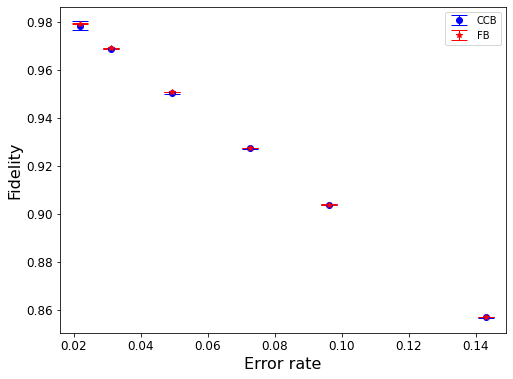

In [682]:
full_mean = [np.mean(full_fitting1), np.mean(full_fitting2), np.mean(full_fitting3), np.mean(full_fitting4), np.mean(full_fitting5), np.mean(full_fitting6)]
fast_mean = [np.mean(fast_fitting1), np.mean(fast_fitting2), np.mean(fast_fitting3), np.mean(fast_fitting4), np.mean(fast_fitting5), np.mean(fast_fitting6)]
full_std = [np.std(full_fitting1), np.std(full_fitting2), np.std(full_fitting3), np.std(full_fitting4), np.std(full_fitting5), np.std(full_fitting6)]
fast_std = [np.std(fast_fitting1), np.std(fast_fitting2), np.std(fast_fitting3), np.std(fast_fitting4), np.std(fast_fitting5), np.std(fast_fitting6)]
ideal_error = [1 - inter_fidelity1, 1 - inter_fidelity2, 1 - inter_fidelity3, 1 - inter_fidelity4, 1 - inter_fidelity5, 1 - inter_fidelity6]
ideal_fidelity = [inter_fidelity1, inter_fidelity2, inter_fidelity3, inter_fidelity4, inter_fidelity5, inter_fidelity6]

plt.figure(figsize = (8, 6))
plt.errorbar(ideal_error, full_mean, yerr = full_std, fmt='o',ecolor='b',color='b',elinewidth = 1,capsize=8)
plt.errorbar(ideal_error, fast_mean, yerr = fast_std, fmt='*',ecolor='r',color='r',elinewidth = 1,capsize=8)

plt.xlabel("Error rate", fontsize = 16)
plt.ylabel("Fidelity", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.legend(["CCB", "FB"], loc = 'upper right') 
plt.savefig('fast-full-error.pdf')



### Normal distribution

#### (1) p_max = 0.995, sigma = 0.004

In [559]:
[set_fidelity, set_var] = [0.995, 0.001]
p_target_list = Pauli_eig(set_fidelity, set_var, num_qubit)
Pauli_chan = PauliChan_surerrep(p_target_list)

c = 0.01
channel_co = (1j * c * qtcir.swap()).expm()
channel_co_superrep = unitary_superrep(channel_co, Pauli_group)

TargetGate_channel1 = np.dot(channel_co_superrep, Pauli_chan)
print('The theoretic process fidelity for the target clifford gate is', process_fidelity(TargetGate_channel1))

channel = np.dot(Pauli_channel, TargetGate_channel1)
ini_fidelity1 = process_fidelity(channel)
print('The fidelity of the error channel is', ini_fidelity1)

channel_Pauli_twirling = twirling(channel, twirling_group)
inter_channel = sqrtm(chop(np.dot(channel_Pauli_twirling, np.dot(np.dot(int_gate, channel_Pauli_twirling), int_gate.T.conjugate()))))
inter_fidelity1 = np.trace(inter_channel) / 4**num_qubit
print('The fidelity of the interleaved error channel is', inter_fidelity1)

The theoretic process fidelity for the target clifford gate is 0.9951736536899201
The fidelity of the error channel is 0.9927862691422886
The fidelity of the interleaved error channel is 0.9927856325786284


In [560]:
seq_length_total1 = 160
seq_length_step1 = 8

In [561]:
full1 = fullRB_fitting_analysis(40, 10, 50, seq_length_total1, seq_length_step1, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel1)

In [562]:
fast1 = fastRB_fitting_analysis(40, 50, seq_length_total1, seq_length_step1, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel1)

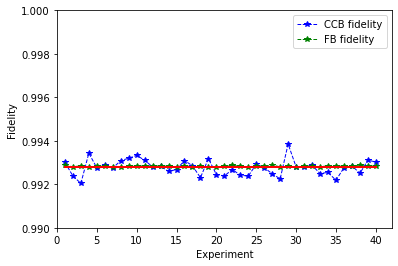

In [563]:
l1, = plt.plot(range(1, 41), full1, color = "b", linestyle = "--", marker = "*", linewidth = 1.0)
l2, = plt.plot(range(1, 41), fast1, color = "g", linestyle = "--", marker = "*", linewidth = 1.0)
plt.plot(range(1, 41), zeros(40) + ini_fidelity1, color = "r", linewidth = 2.0)
plt.plot(range(1, 41), zeros(40) + inter_fidelity1, color = "r", linestyle = "--", linewidth = 2.0)
plt.xlim((0, 42))
plt.ylim((0.99, 1))
plt.xlabel("Experiment")
plt.ylabel("Fidelity")
plt.legend([l1, l2], ['CCB fidelity', 'FB fidelity'], loc = 'upper right')
plt.show()

#### (2) p = 0.99, sigma = 0.002

In [649]:
[set_fidelity, set_var] = [0.99, 0.002]
p_target_list = Pauli_eig(set_fidelity, set_var, num_qubit)
Pauli_chan = PauliChan_surerrep(p_target_list)

c = 0.01
channel_co = (1j * c * qtcir.swap()).expm()
channel_co_superrep = unitary_superrep(channel_co, Pauli_group)

TargetGate_channel2 = np.dot(channel_co_superrep, Pauli_chan)
print('The theoretic process fidelity for the target clifford gate is', process_fidelity(TargetGate_channel2))

channel = np.dot(Pauli_channel, TargetGate_channel2)
ini_fidelity2 = process_fidelity(channel)
print('The fidelity of the error channel is', ini_fidelity2)

channel_Pauli_twirling = twirling(channel, twirling_group)
inter_channel = sqrtm(chop(np.dot(channel_Pauli_twirling, np.dot(np.dot(int_gate, channel_Pauli_twirling), int_gate.T.conjugate()))))
inter_fidelity2 = np.trace(inter_channel) / 4**num_qubit
print('The fidelity of the interleaved error channel is', inter_fidelity2)

The theoretic process fidelity for the target clifford gate is 0.9901852038745168
The fidelity of the error channel is 0.987810831579673
The fidelity of the interleaved error channel is 0.9878102435662133


In [652]:
seq_length_total2 = 100
seq_length_step2 = 10

In [653]:
full2 = fullRB_fitting_analysis(40, 10, 50, seq_length_total2, seq_length_step2, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel2)

In [654]:
fast2 = fastRB_fitting_analysis(40, 50, seq_length_total2, seq_length_step2, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel2)

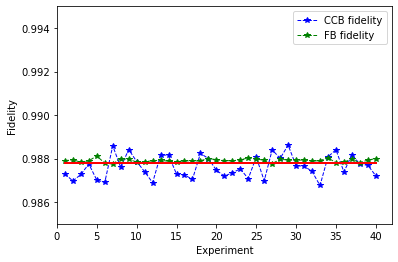

In [655]:
l1, = plt.plot(range(1, 41), full2, color = "b", linestyle = "--", marker = "*", linewidth = 1.0)
l2, = plt.plot(range(1, 41), fast2, color = "g", linestyle = "--", marker = "*", linewidth = 1.0)
plt.plot(range(1, 41), zeros(40) + ini_fidelity2, color = "r", linewidth = 2.0)
plt.plot(range(1, 41), zeros(40) + inter_fidelity2, color = "r", linestyle = "--", linewidth = 2.0)
plt.xlim((0, 42))
plt.ylim((0.985, 0.995))
plt.xlabel("Experiment")
plt.ylabel("Fidelity")
plt.legend([l1, l2], ['CCB fidelity', 'FB fidelity'], loc = 'upper right')
plt.show()

#### (3) p = 0.98, sigma = 0.003

In [576]:
[set_fidelity, set_var] = [0.98, 0.003]
p_target_list = Pauli_eig(set_fidelity, set_var, num_qubit)
Pauli_chan = PauliChan_surerrep(p_target_list)

c = 0.01
channel_co = (1j * c * qtcir.swap()).expm()
channel_co_superrep = unitary_superrep(channel_co, Pauli_group)

TargetGate_channel3 = np.dot(channel_co_superrep, Pauli_chan)
print('The theoretic process fidelity for the target clifford gate is', process_fidelity(TargetGate_channel3))

channel = np.dot(Pauli_channel, TargetGate_channel3)
ini_fidelity3 = process_fidelity(channel)
print('The fidelity of the error channel is', ini_fidelity3)

channel_Pauli_twirling = twirling(channel, twirling_group)
inter_channel = sqrtm(chop(np.dot(channel_Pauli_twirling, np.dot(np.dot(int_gate, channel_Pauli_twirling), int_gate.T.conjugate()))))
inter_fidelity3 = np.trace(inter_channel) / 4**num_qubit
print('The fidelity of the interleaved error channel is', inter_fidelity3)

The theoretic process fidelity for the target clifford gate is 0.979209718706734
The fidelity of the error channel is 0.9768619493668054
The fidelity of the interleaved error channel is 0.9768612623218784


In [577]:
seq_length_total3 = 60
seq_length_step3 = 6

In [578]:
full3 = fullRB_fitting_analysis(40, 10, 50, seq_length_total3, seq_length_step3, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel3)

In [579]:
fast3 = fastRB_fitting_analysis(40, 50, seq_length_total3, seq_length_step3, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel3)

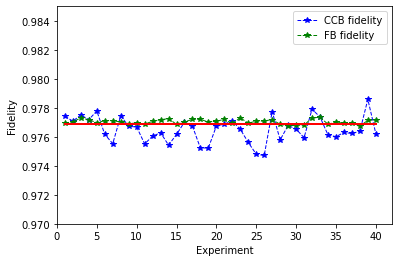

In [580]:
l1, = plt.plot(range(1, 41), full3, color = "b", linestyle = "--", marker = "*", linewidth = 1.0)
l2, = plt.plot(range(1, 41), fast3, color = "g", linestyle = "--", marker = "*", linewidth = 1.0)
plt.plot(range(1, 41), zeros(40) + ini_fidelity3, color = "r", linewidth = 2.0)
plt.plot(range(1, 41), zeros(40) + inter_fidelity3, color = "r", linestyle = "--", linewidth = 2.0)
plt.xlim((0, 42))
plt.ylim((0.97, 0.985))
plt.xlabel("Experiment")
plt.ylabel("Fidelity")
plt.legend([l1, l2], ['CCB fidelity', 'FB fidelity'], loc = 'upper right')
plt.show()

#### (4) p = 0.98, sigma = 0.002

In [581]:
[set_fidelity, set_var] = [0.97, 0.004]
p_target_list = Pauli_eig(set_fidelity, set_var, num_qubit)
Pauli_chan = PauliChan_surerrep(p_target_list)

c = 0.01
channel_co = (1j * c * qtcir.swap()).expm()
channel_co_superrep = unitary_superrep(channel_co, Pauli_group)

TargetGate_channel4 = np.dot(channel_co_superrep, Pauli_chan)
print('The theoretic process fidelity for the target clifford gate is', process_fidelity(TargetGate_channel4))

channel = np.dot(Pauli_channel, TargetGate_channel4)
ini_fidelity4 = process_fidelity(channel)
print('The fidelity of the error channel is', ini_fidelity4)

channel_Pauli_twirling = twirling(channel, twirling_group)
inter_channel = sqrtm(chop(np.dot(channel_Pauli_twirling, np.dot(np.dot(int_gate, channel_Pauli_twirling), int_gate.T.conjugate()))))
inter_fidelity4 = np.trace(inter_channel) / 4**num_qubit
print('The fidelity of the interleaved error channel is', inter_fidelity4)

The theoretic process fidelity for the target clifford gate is 0.9722565162924366
The fidelity of the error channel is 0.969926196900089
The fidelity of the interleaved error channel is 0.9699233841216093


In [582]:
seq_length_total4 = 60
seq_length_step4 = 6

In [583]:
full4 = fullRB_fitting_analysis(40, 10, 50, seq_length_total4, seq_length_step4, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel4)

In [584]:
fast4 = fastRB_fitting_analysis(40, 50, seq_length_total4, seq_length_step4, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel4)

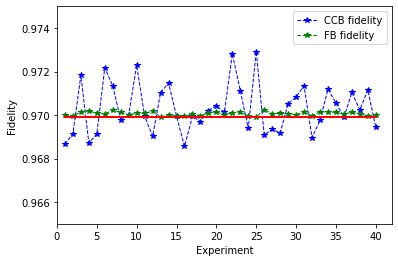

In [585]:
l1, = plt.plot(range(1, 41), full4, color = "b", linestyle = "--", marker = "*", linewidth = 1.0)
l2, = plt.plot(range(1, 41), fast4, color = "g", linestyle = "--", marker = "*", linewidth = 1.0)
plt.plot(range(1, 41), zeros(40) + ini_fidelity4, color = "r", linewidth = 2.0)
plt.plot(range(1, 41), zeros(40) + inter_fidelity4, color = "r", linestyle = "--", linewidth = 2.0)
plt.xlim((0, 42))
plt.ylim((0.965, 0.975))
plt.xlabel("Experiment")
plt.ylabel("Fidelity")
plt.legend([l1, l2], ['CCB fidelity', 'FB fidelity'], loc = 'upper right')
plt.show()

#### (5) p = 0.97, sigma = 0.002

In [586]:
[set_fidelity, set_var] = [0.96, 0.005]
p_target_list = Pauli_eig(set_fidelity, set_var, num_qubit)
Pauli_chan = PauliChan_surerrep(p_target_list)

c = 0.01
channel_co = (1j * c * qtcir.swap()).expm()
channel_co_superrep = unitary_superrep(channel_co, Pauli_group)

TargetGate_channel5 = np.dot(channel_co_superrep, Pauli_chan)
print('The theoretic process fidelity for the target clifford gate is', process_fidelity(TargetGate_channel5))

channel = np.dot(Pauli_channel, TargetGate_channel5)
ini_fidelity5 = process_fidelity(channel)
print('The fidelity of the error channel is', ini_fidelity5)

channel_Pauli_twirling = twirling(channel, twirling_group)
inter_channel = sqrtm(chop(np.dot(channel_Pauli_twirling, np.dot(np.dot(int_gate, channel_Pauli_twirling), int_gate.T.conjugate()))))
inter_fidelity5 = np.trace(inter_channel) / 4**num_qubit
print('The fidelity of the interleaved error channel is', inter_fidelity5)

The theoretic process fidelity for the target clifford gate is 0.9624172485498774
The fidelity of the error channel is 0.9601136923870905
The fidelity of the interleaved error channel is 0.9601087938967399


In [587]:
seq_length_total5 = 30
seq_length_step5 = 2

In [588]:
full5 = fullRB_fitting_analysis(40, 10, 50, seq_length_total5, seq_length_step5, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel5)

In [589]:
fast5 = fastRB_fitting_analysis(40, 50, seq_length_total5, seq_length_step5, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel5)

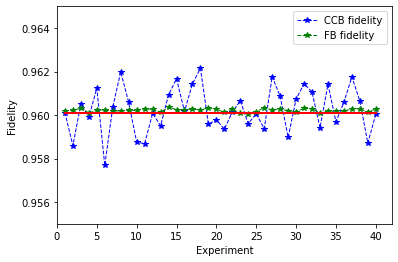

In [591]:
l1, = plt.plot(range(1, 41), full5, color = "b", linestyle = "--", marker = "*", linewidth = 1.0)
l2, = plt.plot(range(1, 41), fast5, color = "g", linestyle = "--", marker = "*", linewidth = 1.0)
plt.plot(range(1, 41), zeros(40) + ini_fidelity5, color = "r", linewidth = 2.0)
plt.plot(range(1, 41), zeros(40) + inter_fidelity5, color = "r", linestyle = "--", linewidth = 2.0)
plt.xlim((0, 42))
plt.ylim((0.955, 0.965))
plt.xlabel("Experiment")
plt.ylabel("Fidelity")
plt.legend([l1, l2], ['CCB fidelity', 'FB fidelity'], loc = 'upper right')
plt.show()

#### (6) p_max = 0.95

In [593]:
[set_fidelity, set_var] = [0.95, 0.006]
p_target_list = Pauli_eig(set_fidelity, set_var, num_qubit)
Pauli_chan = PauliChan_surerrep(p_target_list)

c = 0.01
channel_co = (1j * c * qtcir.swap()).expm()
channel_co_superrep = unitary_superrep(channel_co, Pauli_group)

TargetGate_channel6 = np.dot(channel_co_superrep, Pauli_chan)
print('The theoretic process fidelity for the target clifford gate is', process_fidelity(TargetGate_channel6))

channel = np.dot(Pauli_channel, TargetGate_channel6)
ini_fidelity6 = process_fidelity(channel)
print('The fidelity of the error channel is', ini_fidelity6)

channel_Pauli_twirling = twirling(channel, twirling_group)
inter_channel = sqrtm(chop(np.dot(channel_Pauli_twirling, np.dot(np.dot(int_gate, channel_Pauli_twirling), int_gate.T.conjugate()))))
inter_fidelity6 = np.trace(inter_channel) / 4**num_qubit
print('The fidelity of the interleaved error channel is', inter_fidelity6)

The theoretic process fidelity for the target clifford gate is 0.9518093242342858
The fidelity of the error channel is 0.9495347720667981
The fidelity of the interleaved error channel is 0.9495317361038893


In [597]:
seq_length_total6 = 24
seq_length_step6 = 2

In [598]:
full6 = fullRB_fitting_analysis(40, 10, 50, seq_length_total6, seq_length_step6, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel6)

In [599]:
fast6 = fastRB_fitting_analysis(40, 50, seq_length_total6, seq_length_step6, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel6)

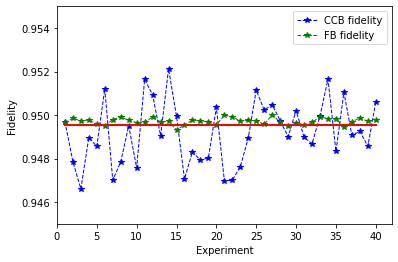

In [600]:
l1, = plt.plot(range(1, 41), full6, color = "b", linestyle = "--", marker = "*", linewidth = 1.0)
l2, = plt.plot(range(1, 41), fast6, color = "g", linestyle = "--", marker = "*", linewidth = 1.0)
plt.plot(range(1, 41), zeros(40) + ini_fidelity6, color = "r", linewidth = 2.0)
plt.plot(range(1, 41), zeros(40) + inter_fidelity6, color = "r", linestyle = "--", linewidth = 2.0)
plt.xlim((0, 42))
plt.ylim((0.945, 0.955))
plt.xlabel("Experiment")
plt.ylabel("Fidelity")
plt.legend([l1, l2], ['CCB fidelity', 'FB fidelity'], loc = 'upper right')
plt.show()

#### (7) p_max = 0.94

In [601]:
[set_fidelity, set_var] = [0.94, 0.007]
p_target_list = Pauli_eig(set_fidelity, set_var, num_qubit)
Pauli_chan = PauliChan_surerrep(p_target_list)

c = 0.01
channel_co = (1j * c * qtcir.swap()).expm()
channel_co_superrep = unitary_superrep(channel_co, Pauli_group)

TargetGate_channel7 = np.dot(channel_co_superrep, Pauli_chan)
print('The theoretic process fidelity for the target clifford gate is', process_fidelity(TargetGate_channel7))

channel = np.dot(Pauli_channel, TargetGate_channel7)
ini_fidelity7 = process_fidelity(channel)
print('The fidelity of the error channel is', ini_fidelity7)

channel_Pauli_twirling = twirling(channel, twirling_group)
inter_channel = sqrtm(chop(np.dot(channel_Pauli_twirling, np.dot(np.dot(int_gate, channel_Pauli_twirling), int_gate.T.conjugate()))))
inter_fidelity7 = np.trace(inter_channel) / 4**num_qubit
print('The fidelity of the interleaved error channel is', inter_fidelity7)

The theoretic process fidelity for the target clifford gate is 0.9421138198801596
The fidelity of the error channel is 0.9398608880918699
The fidelity of the interleaved error channel is 0.9398545155672058


In [602]:
seq_length_total7 = 20
seq_length_step7 = 2

In [603]:
full7 = fullRB_fitting_analysis(40, 10, 50, seq_length_total7, seq_length_step7, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel7)

In [604]:
fast7 = fastRB_fitting_analysis(40, 50, seq_length_total7, seq_length_step7, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel7)

#### (8) p_max = 0.93

In [605]:
[set_fidelity, set_var] = [0.93, 0.008]
p_target_list = Pauli_eig(set_fidelity, set_var, num_qubit)
Pauli_chan = PauliChan_surerrep(p_target_list)

c = 0.01
channel_co = (1j * c * qtcir.swap()).expm()
channel_co_superrep = unitary_superrep(channel_co, Pauli_group)

TargetGate_channel8 = np.dot(channel_co_superrep, Pauli_chan)
print('The theoretic process fidelity for the target clifford gate is', process_fidelity(TargetGate_channel8))

channel = np.dot(Pauli_channel, TargetGate_channel8)
ini_fidelity8 = process_fidelity(channel)
print('The fidelity of the error channel is', ini_fidelity8)

channel_Pauli_twirling = twirling(channel, twirling_group)
inter_channel = sqrtm(chop(np.dot(channel_Pauli_twirling, np.dot(np.dot(int_gate, channel_Pauli_twirling), int_gate.T.conjugate()))))
inter_fidelity8 = np.trace(inter_channel) / 4**num_qubit
print('The fidelity of the interleaved error channel is', inter_fidelity8)

The theoretic process fidelity for the target clifford gate is 0.935270124787637
The fidelity of the error channel is 0.9330368484471365
The fidelity of the interleaved error channel is 0.9330217158164316


In [606]:
seq_length_total8 = 20
seq_length_step8 = 2

In [607]:
full8 = fullRB_fitting_analysis(40, 10, 50, seq_length_total8, seq_length_step8, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel8)

In [608]:
fast8 = fastRB_fitting_analysis(40, 50, seq_length_total8, seq_length_step8, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel8)

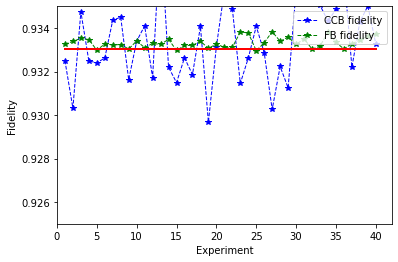

In [609]:
l1, = plt.plot(range(1, 41), full8, color = "b", linestyle = "--", marker = "*", linewidth = 1.0)
l2, = plt.plot(range(1, 41), fast8, color = "g", linestyle = "--", marker = "*", linewidth = 1.0)
plt.plot(range(1, 41), zeros(40) + ini_fidelity8, color = "r", linewidth = 2.0)
plt.plot(range(1, 41), zeros(40) + inter_fidelity8, color = "r", linestyle = "--", linewidth = 2.0)
plt.xlim((0, 42))
plt.ylim((0.925, 0.935))
plt.xlabel("Experiment")
plt.ylabel("Fidelity")
plt.legend([l1, l2], ['CCB fidelity', 'FB fidelity'], loc = 'upper right')
plt.show()

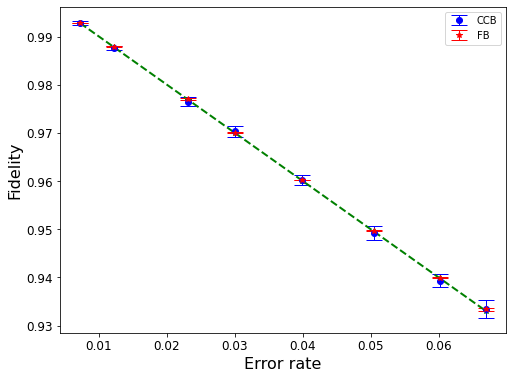

In [657]:
full_mean = [np.mean(full1), np.mean(full2), np.mean(full3), np.mean(full4), np.mean(full5), np.mean(full6), np.mean(full7), np.mean(full8)]
fast_mean = [np.mean(fast1), np.mean(fast2), np.mean(fast3), np.mean(fast4), np.mean(fast5), np.mean(fast6), np.mean(fast7), np.mean(fast8)]
full_std = [np.std(full1), np.std(full2), np.std(full3), np.std(full4), np.std(full5), np.std(full6), np.std(full7), np.std(full8)]
fast_std = [np.std(fast1), np.std(fast2), np.std(fast3), np.std(fast4), np.std(fast5), np.std(fast6), np.std(fast7), np.std(fast8)]
ideal_error = [1 - inter_fidelity1, 1 - inter_fidelity2, 1 - inter_fidelity3, 1 - inter_fidelity4, 1 - inter_fidelity5, 1 - inter_fidelity6, 1 - inter_fidelity7, 1 - inter_fidelity8]
ideal_fidelity = [inter_fidelity1, inter_fidelity2, inter_fidelity3, inter_fidelity4, inter_fidelity5, inter_fidelity6, inter_fidelity7, inter_fidelity8]

plt.figure(figsize = (8, 6))
plt.errorbar(ideal_error, full_mean, yerr = full_std, fmt='o',ecolor='b',color='b',elinewidth = 1,capsize=8)
plt.errorbar(ideal_error, fast_mean, yerr = fast_std, fmt='*',ecolor='r',color='r',elinewidth = 1,capsize=8)

plt.xlabel("Error rate", fontsize = 16)
plt.ylabel("Fidelity", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.legend(["CCB", "FB"], loc = 'upper right') 
plt.plot(ideal_error, ideal_fidelity, color = "g", linestyle = "--", marker = "*", linewidth = 2.0)
plt.savefig('fast_full_error.pdf')

#### (1) p_max = 0.999, delta = 0.001

In [282]:
p_target_list = np.arange(0.999, 0.999 - (4**num_qubit - 1) * 0.001 + 0.0001, - 0.001)
Pauli_chan = PauliChan_surerrep(p_target_list)

c = 0.01
channel_co = (1j * c * qtcir.swap()).expm()
channel_co_superrep = unitary_superrep(channel_co, Pauli_group)

TargetGate_channel1 = np.dot(channel_co_superrep, Pauli_chan)
print('The theoretic process fidelity for the target clifford gate is', process_fidelity(TargetGate_channel1))

channel = np.dot(Pauli_channel, TargetGate_channel1)
ini_fidelity1 = process_fidelity(channel)
print('The fidelity of the error channel is', ini_fidelity1)

channel_Pauli_twirling = twirling(channel, twirling_group)
inter_channel = sqrtm(chop(np.dot(channel_Pauli_twirling, np.dot(np.dot(int_gate, channel_Pauli_twirling), int_gate.T.conjugate()))))
inter_fidelity1 = np.trace(inter_channel) / 4**num_qubit
print('The fidelity of the interleaved error channel is', inter_fidelity1)

The theoretic process fidelity for the target clifford gate is 0.9924255649812167
The fidelity of the error channel is 0.9900474064769076
The fidelity of the interleaved error channel is 0.9900404720255613


In [283]:
seq_length_total1 = 100
seq_length_step1 = 8

In [284]:
full21 = fullRB_fitting_analysis(40, 10, 50, seq_length_total1, seq_length_step1, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel1)

In [285]:
fast21 = fastRB_fitting_analysis(40, 50, seq_length_total1, seq_length_step1, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel1)

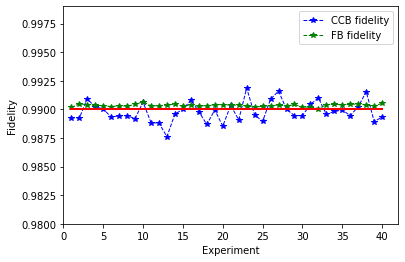

In [287]:
l1, = plt.plot(range(1, 41), full21, color = "b", linestyle = "--", marker = "*", linewidth = 1.0)
l2, = plt.plot(range(1, 41), fast21, color = "g", linestyle = "--", marker = "*", linewidth = 1.0)
plt.plot(range(1, 41), zeros(40) + ini_fidelity1, color = "r", linewidth = 2.0)
plt.plot(range(1, 41), zeros(40) + inter_fidelity1, color = "r", linestyle = "--", linewidth = 2.0)
plt.xlim((0, 42))
plt.ylim((0.98, 0.999))
plt.xlabel("Experiment")
plt.ylabel("Fidelity")
plt.legend([l1, l2], ['CCB fidelity', 'FB fidelity'], loc = 'upper right')
plt.show()

#### (2) p_max = 0.999, delta = 0.003

In [291]:
p_target_list = np.arange(0.999, 0.999 - (4**num_qubit - 1) * 0.003 + 0.0001, - 0.003)
Pauli_chan = PauliChan_surerrep(p_target_list)

c = 0.01
channel_co = (1j * c * qtcir.swap()).expm()
channel_co_superrep = unitary_superrep(channel_co, Pauli_group)

TargetGate_channel2 = np.dot(channel_co_superrep, Pauli_chan)
print('The theoretic process fidelity for the target clifford gate is', process_fidelity(TargetGate_channel2))

channel = np.dot(Pauli_channel, TargetGate_channel2)
ini_fidelity2 = process_fidelity(channel)
print('The fidelity of the error channel is', ini_fidelity2)

channel_Pauli_twirling = twirling(channel, twirling_group)
inter_channel = sqrtm(chop(np.dot(channel_Pauli_twirling, np.dot(np.dot(int_gate, channel_Pauli_twirling), int_gate.T.conjugate()))))
inter_fidelity2 = np.trace(inter_channel) / 4**num_qubit
print('The fidelity of the interleaved error channel is', inter_fidelity2)

The theoretic process fidelity for the target clifford gate is 0.9793015399487173
The fidelity of the error channel is 0.9769619225957542
The fidelity of the interleaved error channel is 0.9769101661382813


In [294]:
seq_length_total2 = 60
seq_length_step2 = 6

In [295]:
full22 = fullRB_fitting_analysis(40, 10, 50, seq_length_total2, seq_length_step2, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel2)

In [296]:
fast22 = fastRB_fitting_analysis(40, 50, seq_length_total2, seq_length_step2, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel2)

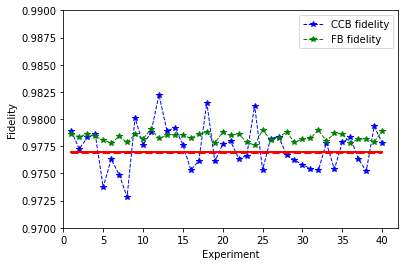

In [299]:
l1, = plt.plot(range(1, 41), full22, color = "b", linestyle = "--", marker = "*", linewidth = 1.0)
l2, = plt.plot(range(1, 41), fast22, color = "g", linestyle = "--", marker = "*", linewidth = 1.0)
plt.plot(range(1, 41), zeros(40) + ini_fidelity2, color = "r", linewidth = 2.0)
plt.plot(range(1, 41), zeros(40) + inter_fidelity2, color = "r", linestyle = "--", linewidth = 2.0)
plt.xlim((0, 42))
plt.ylim((0.97, 0.99))
plt.xlabel("Experiment")
plt.ylabel("Fidelity")
plt.legend([l1, l2], ['CCB fidelity', 'FB fidelity'], loc = 'upper right')
plt.show()

#### (3) p_max = 0.999, delta = 0.005

In [300]:
p_target_list = np.arange(0.999, 0.999 - (4**num_qubit - 1) * 0.005 + 0.0001, - 0.005)
Pauli_chan = PauliChan_surerrep(p_target_list)

c = 0.01
channel_co = (1j * c * qtcir.swap()).expm()
channel_co_superrep = unitary_superrep(channel_co, Pauli_group)

TargetGate_channel3 = np.dot(channel_co_superrep, Pauli_chan)
print('The theoretic process fidelity for the target clifford gate is', process_fidelity(TargetGate_channel3))

channel = np.dot(Pauli_channel, TargetGate_channel3)
ini_fidelity3 = process_fidelity(channel)
print('The fidelity of the error channel is', ini_fidelity3)

channel_Pauli_twirling = twirling(channel, twirling_group)
inter_channel = sqrtm(chop(np.dot(channel_Pauli_twirling, np.dot(np.dot(int_gate, channel_Pauli_twirling), int_gate.T.conjugate()))))
inter_fidelity3 = np.trace(inter_channel) / 4**num_qubit
print('The fidelity of the interleaved error channel is', inter_fidelity3)

The theoretic process fidelity for the target clifford gate is 0.9661775149162176
The fidelity of the error channel is 0.9638764387146008
The fidelity of the interleaved error channel is 0.9637364907244571


In [302]:
seq_length_total3 = 40
seq_length_step3 = 4

In [303]:
full23 = fullRB_fitting_analysis(40, 10, 50, seq_length_total3, seq_length_step3, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel3)

In [304]:
fast23 = fastRB_fitting_analysis(40, 50, seq_length_total3, seq_length_step3, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel3)

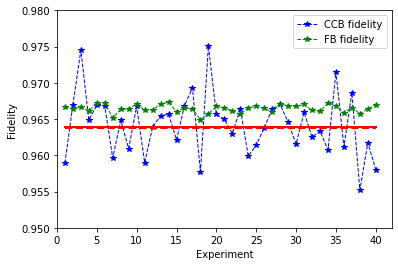

In [306]:
l1, = plt.plot(range(1, 41), full23, color = "b", linestyle = "--", marker = "*", linewidth = 1.0)
l2, = plt.plot(range(1, 41), fast23, color = "g", linestyle = "--", marker = "*", linewidth = 1.0)
plt.plot(range(1, 41), zeros(40) + ini_fidelity3, color = "r", linewidth = 2.0)
plt.plot(range(1, 41), zeros(40) + inter_fidelity3, color = "r", linestyle = "--", linewidth = 2.0)
plt.xlim((0, 42))
plt.ylim((0.95, 0.98))
plt.xlabel("Experiment")
plt.ylabel("Fidelity")
plt.legend([l1, l2], ['CCB fidelity', 'FB fidelity'], loc = 'upper right')
plt.show()

#### (4) p_max = 0.999, delta = 0.007

In [307]:
p_target_list = np.arange(0.999, 0.999 - (4**num_qubit - 1) * 0.007 + 0.0001, - 0.007)
Pauli_chan = PauliChan_surerrep(p_target_list)

c = 0.01
channel_co = (1j * c * qtcir.swap()).expm()
channel_co_superrep = unitary_superrep(channel_co, Pauli_group)

TargetGate_channel4 = np.dot(channel_co_superrep, Pauli_chan)
print('The theoretic process fidelity for the target clifford gate is', process_fidelity(TargetGate_channel4))

channel = np.dot(Pauli_channel, TargetGate_channel4)
ini_fidelity4 = process_fidelity(channel)
print('The fidelity of the error channel is', ini_fidelity4)

channel_Pauli_twirling = twirling(channel, twirling_group)
inter_channel = sqrtm(chop(np.dot(channel_Pauli_twirling, np.dot(np.dot(int_gate, channel_Pauli_twirling), int_gate.T.conjugate()))))
inter_fidelity4 = np.trace(inter_channel) / 4**num_qubit
print('The fidelity of the interleaved error channel is', inter_fidelity4)

The theoretic process fidelity for the target clifford gate is 0.953053489883718
The fidelity of the error channel is 0.9507909548334473
The fidelity of the interleaved error channel is 0.9505173523084842


In [385]:
seq_length_total4 = 24
seq_length_step4 = 2

In [386]:
full24 = fullRB_fitting_analysis(40, 10, 50, seq_length_total4, seq_length_step4, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel4)

In [314]:
fast24 = fastRB_fitting_analysis(40, 50, seq_length_total4, seq_length_step4, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel4)

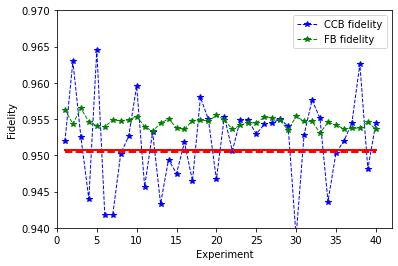

In [315]:
l1, = plt.plot(range(1, 41), full24, color = "b", linestyle = "--", marker = "*", linewidth = 1.0)
l2, = plt.plot(range(1, 41), fast24, color = "g", linestyle = "--", marker = "*", linewidth = 1.0)
plt.plot(range(1, 41), zeros(40) + ini_fidelity4, color = "r", linewidth = 2.0)
plt.plot(range(1, 41), zeros(40) + inter_fidelity4, color = "r", linestyle = "--", linewidth = 2.0)
plt.xlim((0, 42))
plt.ylim((0.94, 0.97))
plt.xlabel("Experiment")
plt.ylabel("Fidelity")
plt.legend([l1, l2], ['CCB fidelity', 'FB fidelity'], loc = 'upper right')
plt.show()

#### (5) p_max = 0.999, delta = 0.009

In [318]:
p_target_list = np.arange(0.999, 0.999 - (4**num_qubit - 1) * 0.009 + 0.0001, - 0.009)
Pauli_chan = PauliChan_surerrep(p_target_list)

c = 0.01
channel_co = (1j * c * qtcir.swap()).expm()
channel_co_superrep = unitary_superrep(channel_co, Pauli_group)

TargetGate_channel5 = np.dot(channel_co_superrep, Pauli_chan)
print('The theoretic process fidelity for the target clifford gate is', process_fidelity(TargetGate_channel5))

channel = np.dot(Pauli_channel, TargetGate_channel5)
ini_fidelity5 = process_fidelity(channel)
print('The fidelity of the error channel is', ini_fidelity5)

channel_Pauli_twirling = twirling(channel, twirling_group)
inter_channel = sqrtm(chop(np.dot(channel_Pauli_twirling, np.dot(np.dot(int_gate, channel_Pauli_twirling), int_gate.T.conjugate()))))
inter_fidelity5 = np.trace(inter_channel) / 4**num_qubit
print('The fidelity of the interleaved error channel is', inter_fidelity5)

The theoretic process fidelity for the target clifford gate is 0.9399294648512184
The fidelity of the error channel is 0.9377054709522938
The fidelity of the interleaved error channel is 0.9372504974910489


In [320]:
seq_length_total5 = 20
seq_length_step5 = 2

In [321]:
full25 = fullRB_fitting_analysis(40, 10, 50, seq_length_total5, seq_length_step5, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel5)

In [322]:
fast25 = fastRB_fitting_analysis(40, 50, seq_length_total5, seq_length_step5, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel5)

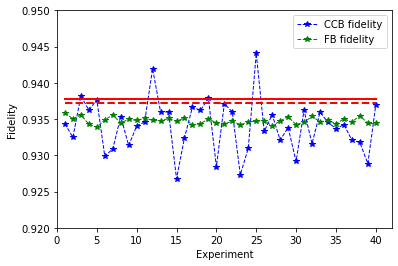

In [323]:
l1, = plt.plot(range(1, 41), full5, color = "b", linestyle = "--", marker = "*", linewidth = 1.0)
l2, = plt.plot(range(1, 41), fast5, color = "g", linestyle = "--", marker = "*", linewidth = 1.0)
plt.plot(range(1, 41), zeros(40) + ini_fidelity5, color = "r", linewidth = 2.0)
plt.plot(range(1, 41), zeros(40) + inter_fidelity5, color = "r", linestyle = "--", linewidth = 2.0)
plt.xlim((0, 42))
plt.ylim((0.92, 0.95))
plt.xlabel("Experiment")
plt.ylabel("Fidelity")
plt.legend([l1, l2], ['CCB fidelity', 'FB fidelity'], loc = 'upper right')
plt.show()

#### (6) p_max = 0.999, delta = 0.011

In [325]:
p_target_list = np.arange(0.999, 0.999 - (4**num_qubit - 1) * 0.011 + 0.0001, - 0.011)
Pauli_chan = PauliChan_surerrep(p_target_list)

c = 0.01
channel_co = (1j * c * qtcir.swap()).expm()
channel_co_superrep = unitary_superrep(channel_co, Pauli_group)

TargetGate_channel6 = np.dot(channel_co_superrep, Pauli_chan)
print('The theoretic process fidelity for the target clifford gate is', process_fidelity(TargetGate_channel6))

channel = np.dot(Pauli_channel, TargetGate_channel6)
ini_fidelity6 = process_fidelity(channel)
print('The fidelity of the error channel is', ini_fidelity6)

channel_Pauli_twirling = twirling(channel, twirling_group)
inter_channel = sqrtm(chop(np.dot(channel_Pauli_twirling, np.dot(np.dot(int_gate, channel_Pauli_twirling), int_gate.T.conjugate()))))
inter_fidelity6 = np.trace(inter_channel) / 4**num_qubit
print('The fidelity of the interleaved error channel is', inter_fidelity6)

The theoretic process fidelity for the target clifford gate is 0.9268054398187189
The fidelity of the error channel is 0.9246199870711405
The fidelity of the interleaved error channel is 0.9239334956498306


In [327]:
seq_length_total6 = 20
seq_length_step6 = 2

In [328]:
full26 = fullRB_fitting_analysis(40, 10, 50, seq_length_total6, seq_length_step6, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel6)

In [329]:
fast26 = fastRB_fitting_analysis(40, 50, seq_length_total6, seq_length_step6, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel6)

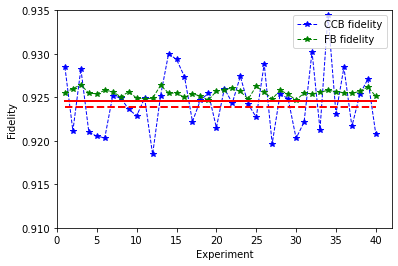

In [330]:
l1, = plt.plot(range(1, 41), full6, color = "b", linestyle = "--", marker = "*", linewidth = 1.0)
l2, = plt.plot(range(1, 41), fast6, color = "g", linestyle = "--", marker = "*", linewidth = 1.0)
plt.plot(range(1, 41), zeros(40) + ini_fidelity6, color = "r", linewidth = 2.0)
plt.plot(range(1, 41), zeros(40) + inter_fidelity6, color = "r", linestyle = "--", linewidth = 2.0)
plt.xlim((0, 42))
plt.ylim((0.91, 0.935))
plt.xlabel("Experiment")
plt.ylabel("Fidelity")
plt.legend([l1, l2], ['CCB fidelity', 'FB fidelity'], loc = 'upper right')
plt.show()

#### (7)  p_max = 0.999, delta = 0.002

In [337]:
p_target_list = np.arange(0.999, 0.999 - (4**num_qubit - 1) * 0.002 + 0.0001, - 0.002)
Pauli_chan = PauliChan_surerrep(p_target_list)

c = 0.01
channel_co = (1j * c * qtcir.swap()).expm()
channel_co_superrep = unitary_superrep(channel_co, Pauli_group)

TargetGate_channel7 = np.dot(channel_co_superrep, Pauli_chan)
print('The theoretic process fidelity for the target clifford gate is', process_fidelity(TargetGate_channel7))

channel = np.dot(Pauli_channel, TargetGate_channel7)
ini_fidelity7 = process_fidelity(channel)
print('The fidelity of the error channel is', ini_fidelity7)

channel_Pauli_twirling = twirling(channel, twirling_group)
inter_channel = sqrtm(chop(np.dot(channel_Pauli_twirling, np.dot(np.dot(int_gate, channel_Pauli_twirling), int_gate.T.conjugate()))))
inter_fidelity7 = np.trace(inter_channel) / 4**num_qubit
print('The fidelity of the interleaved error channel is', inter_fidelity7)

The theoretic process fidelity for the target clifford gate is 0.985863552464967
The fidelity of the error channel is 0.983504664536331
The fidelity of the interleaved error channel is 0.9834806152491513


In [338]:
seq_length_total7 = 60
seq_length_step7 = 6

In [339]:
full27 = fullRB_fitting_analysis(40, 10, 50, seq_length_total7, seq_length_step7, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel7)

In [340]:
fast27 = fastRB_fitting_analysis(40, 50, seq_length_total7, seq_length_step7, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel7)

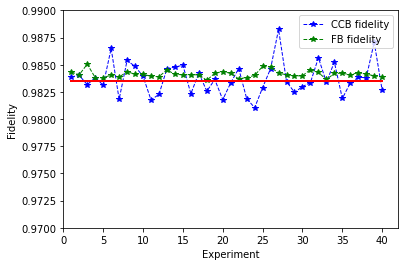

In [380]:
l1, = plt.plot(range(1, 41), full27, color = "b", linestyle = "--", marker = "*", linewidth = 1.0)
l2, = plt.plot(range(1, 41), fast27, color = "g", linestyle = "--", marker = "*", linewidth = 1.0)
plt.plot(range(1, 41), zeros(40) + ini_fidelity7, color = "r", linewidth = 2.0)
plt.plot(range(1, 41), zeros(40) + inter_fidelity7, color = "r", linestyle = "--", linewidth = 2.0)
plt.xlim((0, 42))
plt.ylim((0.97, 0.99))
plt.xlabel("Experiment")
plt.ylabel("Fidelity")
plt.legend([l1, l2], ['CCB fidelity', 'FB fidelity'], loc = 'upper right')
plt.show()

#### (8) p_max = 0.999, delta = 0.004

In [342]:
p_target_list = np.arange(0.999, 0.999 - (4**num_qubit - 1) * 0.004 + 0.0001, - 0.004)
Pauli_chan = PauliChan_surerrep(p_target_list)

c = 0.01
channel_co = (1j * c * qtcir.swap()).expm()
channel_co_superrep = unitary_superrep(channel_co, Pauli_group)

TargetGate_channel8 = np.dot(channel_co_superrep, Pauli_chan)
print('The theoretic process fidelity for the target clifford gate is', process_fidelity(TargetGate_channel8))

channel = np.dot(Pauli_channel, TargetGate_channel8)
ini_fidelity8 = process_fidelity(channel)
print('The fidelity of the error channel is', ini_fidelity8)

channel_Pauli_twirling = twirling(channel, twirling_group)
inter_channel = sqrtm(chop(np.dot(channel_Pauli_twirling, np.dot(np.dot(int_gate, channel_Pauli_twirling), int_gate.T.conjugate()))))
inter_fidelity8 = np.trace(inter_channel) / 4**num_qubit
print('The fidelity of the interleaved error channel is', inter_fidelity8)

The theoretic process fidelity for the target clifford gate is 0.9727395274324673
The fidelity of the error channel is 0.9704191806551774
The fidelity of the interleaved error channel is 0.9703288769037108


In [343]:
seq_length_total8 = 60
seq_length_step8 = 6

In [382]:
full28 = fullRB_fitting_analysis(40, 10, 50, seq_length_total8, seq_length_step8, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel8)

In [347]:
fast28 = fastRB_fitting_analysis(40, 50, seq_length_total8, seq_length_step8, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel8)

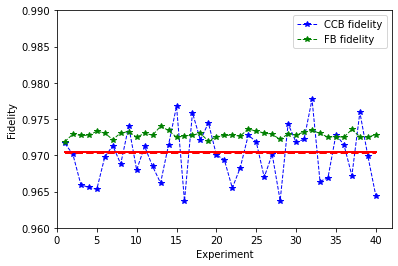

In [383]:
l1, = plt.plot(range(1, 41), full28, color = "b", linestyle = "--", marker = "*", linewidth = 1.0)
l2, = plt.plot(range(1, 41), fast28, color = "g", linestyle = "--", marker = "*", linewidth = 1.0)
plt.plot(range(1, 41), zeros(40) + ini_fidelity8, color = "r", linewidth = 2.0)
plt.plot(range(1, 41), zeros(40) + inter_fidelity8, color = "r", linestyle = "--", linewidth = 2.0)
plt.xlim((0, 42))
plt.ylim((0.96, 0.99))
plt.xlabel("Experiment")
plt.ylabel("Fidelity")
plt.legend([l1, l2], ['CCB fidelity', 'FB fidelity'], loc = 'upper right')
plt.show()

#### (9) p_max = 0.999, delta = 0.006

In [360]:
p_target_list = np.arange(0.999, 0.999 - (4**num_qubit - 1) * 0.006 + 0.0001, - 0.006)
Pauli_chan = PauliChan_surerrep(p_target_list)

c = 0.01
channel_co = (1j * c * qtcir.swap()).expm()
channel_co_superrep = unitary_superrep(channel_co, Pauli_group)

TargetGate_channel9 = np.dot(channel_co_superrep, Pauli_chan)
print('The theoretic process fidelity for the target clifford gate is', process_fidelity(TargetGate_channel9))

channel = np.dot(Pauli_channel, TargetGate_channel9)
ini_fidelity9 = process_fidelity(channel)
print('The fidelity of the error channel is', ini_fidelity9)

channel_Pauli_twirling = twirling(channel, twirling_group)
inter_channel = sqrtm(chop(np.dot(channel_Pauli_twirling, np.dot(np.dot(int_gate, channel_Pauli_twirling), int_gate.T.conjugate()))))
inter_fidelity9 = np.trace(inter_channel) / 4**num_qubit
print('The fidelity of the interleaved error channel is', inter_fidelity9)

The theoretic process fidelity for the target clifford gate is 0.9596155023999678
The fidelity of the error channel is 0.957333696774024
The fidelity of the interleaved error channel is 0.9571327412893771


In [361]:
seq_length_total9 = 24
seq_length_step9 = 2

In [363]:
full29 = fullRB_fitting_analysis(40, 10, 50, seq_length_total9, seq_length_step9, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel9)

In [365]:
fast29 = fastRB_fitting_analysis(40, 50, seq_length_total9, seq_length_step9, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel9)

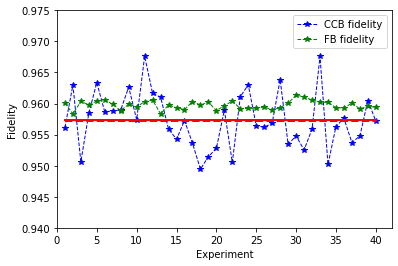

In [367]:
l1, = plt.plot(range(1, 41), full29, color = "b", linestyle = "--", marker = "*", linewidth = 1.0)
l2, = plt.plot(range(1, 41), fast29, color = "g", linestyle = "--", marker = "*", linewidth = 1.0)
plt.plot(range(1, 41), zeros(40) + ini_fidelity9, color = "r", linewidth = 2.0)
plt.plot(range(1, 41), zeros(40) + inter_fidelity9, color = "r", linestyle = "--", linewidth = 2.0)
plt.xlim((0, 42))
plt.ylim((0.94, 0.975))
plt.xlabel("Experiment")
plt.ylabel("Fidelity")
plt.legend([l1, l2], ['CCB fidelity', 'FB fidelity'], loc = 'upper right')
plt.show()

#### (10) p_max = 0.999, delta = 0.008

In [374]:
p_target_list = np.arange(0.999, 0.999 - (4**num_qubit - 1) * 0.008 + 0.0001, - 0.008)
Pauli_chan = PauliChan_surerrep(p_target_list)

c = 0.01
channel_co = (1j * c * qtcir.swap()).expm()
channel_co_superrep = unitary_superrep(channel_co, Pauli_group)

TargetGate_channel10 = np.dot(channel_co_superrep, Pauli_chan)
print('The theoretic process fidelity for the target clifford gate is', process_fidelity(TargetGate_channel10))

channel = np.dot(Pauli_channel, TargetGate_channel10)
ini_fidelity10 = process_fidelity(channel)
print('The fidelity of the error channel is', ini_fidelity10)

channel_Pauli_twirling = twirling(channel, twirling_group)
inter_channel = sqrtm(chop(np.dot(channel_Pauli_twirling, np.dot(np.dot(int_gate, channel_Pauli_twirling), int_gate.T.conjugate()))))
inter_fidelity10 = np.trace(inter_channel) / 4**num_qubit
print('The fidelity of the interleaved error channel is', inter_fidelity10)

The theoretic process fidelity for the target clifford gate is 0.9464914773674682
The fidelity of the error channel is 0.9442482128928705
The fidelity of the interleaved error channel is 0.9438900369915203


In [375]:
seq_length_total10 = 24
seq_length_step10 = 2

In [376]:
full210 = fullRB_fitting_analysis(40, 10, 50, seq_length_total10, seq_length_step10, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel10)

In [377]:
fast210 = fastRB_fitting_analysis(40, 50, seq_length_total10, seq_length_step10, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel10)

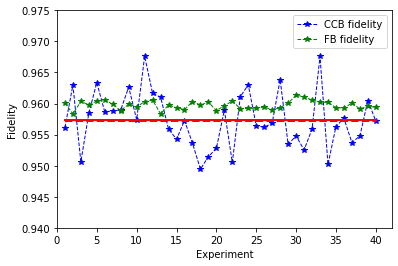

In [367]:
l1, = plt.plot(range(1, 41), full210, color = "b", linestyle = "--", marker = "*", linewidth = 1.0)
l2, = plt.plot(range(1, 41), fast210, color = "g", linestyle = "--", marker = "*", linewidth = 1.0)
plt.plot(range(1, 41), zeros(40) + ini_fidelity10, color = "r", linewidth = 2.0)
plt.plot(range(1, 41), zeros(40) + inter_fidelity10, color = "r", linestyle = "--", linewidth = 2.0)
plt.xlim((0, 42))
plt.ylim((0.935, 0.955))
plt.xlabel("Experiment")
plt.ylabel("Fidelity")
plt.legend([l1, l2], ['CCB fidelity', 'FB fidelity'], loc = 'upper right')
plt.show()

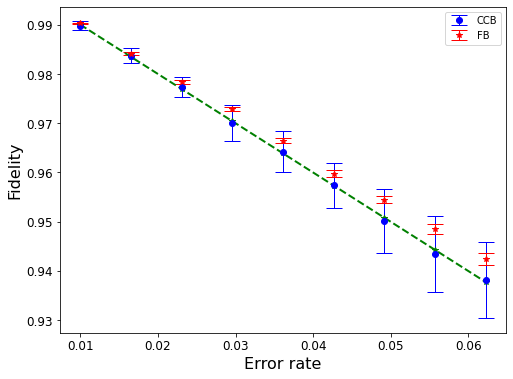

In [402]:
full_mean = [np.mean(full21), np.mean(full27), np.mean(full22), np.mean(full28), np.mean(full23), np.mean(full29), np.mean(full24), np.mean(full210), np.mean(full25)]
fast_mean = [np.mean(fast21), np.mean(fast27), np.mean(fast22), np.mean(fast28), np.mean(fast23), np.mean(fast29), np.mean(fast24), np.mean(fast210), np.mean(fast25)]
full_std = [np.std(full21), np.std(full27), np.std(full22), np.std(full28), np.std(full23), np.std(full29), np.std(full24), np.std(full210), np.std(full25)]
fast_std = [np.std(fast21), np.std(fast27), np.std(fast22), np.std(fast28), np.std(fast23), np.std(fast29), np.std(fast24), np.std(fast210), np.std(fast25)]
ideal_error = [1-ini_fidelity1, 1-ini_fidelity7, 1-ini_fidelity2, 1-ini_fidelity8, 1-ini_fidelity3, 1-ini_fidelity9, 1-ini_fidelity4, 1-ini_fidelity10, 1-ini_fidelity5]
ideal_fidelity = [ini_fidelity1, ini_fidelity7, ini_fidelity2, ini_fidelity8, ini_fidelity3, ini_fidelity9, ini_fidelity4, ini_fidelity10, ini_fidelity5]

plt.figure(figsize = (8, 6))
plt.errorbar(ideal_error, full_mean, yerr = full_std, fmt='o',ecolor='b',color='b',elinewidth = 1,capsize=8)
plt.errorbar(ideal_error, fast_mean, yerr = fast_std, fmt='*',ecolor='r',color='r',elinewidth = 1,capsize=8)
plt.legend(["CCB", "FB"], loc = 'upper right') 

plt.xlabel("Error rate", fontsize = 16)
plt.ylabel("Fidelity", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.plot(ideal_error, ideal_fidelity, color = "g", linestyle = "--", marker = "*", linewidth = 2.0)
plt.savefig('fast_full_error.pdf')

### Fast fitting figure

In [403]:
p_target_list = np.arange(0.999, 0.999 - (4**num_qubit - 1) * 0.002 + 0.0001, - 0.002)
Pauli_chan = PauliChan_surerrep(p_target_list)

c = 0.01
channel_co = (1j * c * qtcir.swap()).expm()
channel_co_superrep = unitary_superrep(channel_co, Pauli_group)

TargetGate_channel_fast = np.dot(channel_co_superrep, Pauli_chan)
print('The theoretic process fidelity for the target clifford gate is', process_fidelity(TargetGate_channel_fast))

channel = np.dot(Pauli_channel, TargetGate_channel_fast)
ini_fidelity_fast = process_fidelity(channel)
print('The fidelity of the error channel is', ini_fidelity_fast)

channel_Pauli_twirling = twirling(channel, twirling_group)
inter_channel = sqrtm(chop(np.dot(channel_Pauli_twirling, np.dot(np.dot(int_gate, channel_Pauli_twirling), int_gate.T.conjugate()))))
inter_fidelity_fast = np.trace(inter_channel) / 4**num_qubit
print('The fidelity of the interleaved error channel is', inter_fidelity_fast)

The theoretic process fidelity for the target clifford gate is 0.985863552464967
The fidelity of the error channel is 0.983504664536331
The fidelity of the interleaved error channel is 0.9834806152491513


In [407]:
seq_length_total_fast = 67
seq_length_step_fast = 6

In [408]:
fitting_pre = fast_fitting_pre(80, 50, seq_length_total_fast, seq_length_step_fast, int_gate, SPAM_channel, ref_gate_channel, TargetGate_channel_fast)

<Figure size 576x432 with 0 Axes>

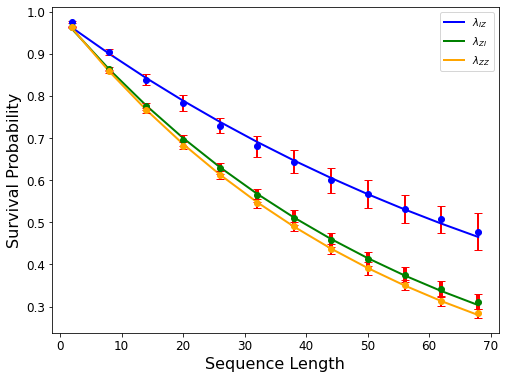

In [413]:
fast_fitting_figure(fitting_pre, seq_length_step)